# Enrichment HMP 16S - Subgingival vs Supragingival - Data from Calgaro, 2020

In this notebook, the enrichment results from Calgaro, 2020 are reproduced using the NYCHANES biosis dataset (manually curated). The same procedure is done using annotations from the aerophilicity dataset from bugphyzz (result of web scraping).

In Calgaro, 2020 the enrichment analysis was done with the Fisher's exact test using six contingency tables:  
- Aerobic taxa "Up-regulated" in Subgingival.  
- Aerobic taxa "Down-regulated" in Subgingival.  
- Anaerobic taxa "Up-regulated" in Subgingival.  
- Anaerobic taxa "Down-regulated" in Subgingival.  
- Facultatively Anaerobic taxa "Up-regulated" in Subgingival.  
- Facultatively Anaerobic taxa "Down-regulated" in Subgingival.  

The same contingency tables are reproduced in this notebook with the bugphyzz annotations.

Furthermore, the enrichment analyses will be done using the EnrichmentBrowser package ("ora").

An important distinction between the approach used in Calgaro,2020 and EnrichmentBrowser is that the latter uses alll differentially abudant (DA) taxa, i.e. regardless if they're of "up-" or "down-regulated", for gene set analysis. This would be equivalent to having only three contingency tables (DA aerobic, DA anaerobic, and DA facultatively anaerobic).


In [1]:
suppressMessages({
    library(phyloseq)
    library(DESeq2)
    library(SummarizedExperiment)
    library(magrittr)
    library(dplyr)
    library(tidyr)
    library(ggplot2)
})

## Functions

A function to create a list of contingency tables from annotations in a SummarizedExperiment object:

In [2]:
contingencyTable <- function(x, diffcols, sigcols) {
        
    row_data <- SummarizedExperiment::rowData(x) %>% 
        tibble::as_tibble(rownames = "rowname")
    col_data <- SummarizedExperiment::colData(x) %>% 
        tibble::as_tibble(rownames = "rowname")
    
    for (i in seq_along(diffcols)) {
        row_data[diffcols[i]] <- factor(row_data[[diffcols[i]]], levels = c("TRUE", "FALSE"), labels = c("Diff", "NotDiff"))
    }
    
    for (j in seq_along(sigcols)) {
        row_data[[sigcols[j]]] = factor(row_data[[sigcols[j]]], levels = c("TRUE", "FALSE"), labels = c(sigcols[j], paste0("Not", sigcols[j])))
    }
    
    vctr_len <- length(diffcols) * length(sigcols)
    output <- vector("list", vctr_len)
    counter <- 1
    
    for (i in seq_along(diffcols)) {
        for (j in seq_along(sigcols)){
            
            form <- paste0("~ ", diffcols[i], " + ", sigcols[j])
            contigency_table <- stats::xtabs(form, data = row_data)
            output[[counter]] <- contigency_table
            names(output)[counter] <- paste0(diffcols[i], "_" ,sigcols[j])
            counter <- counter + 1
        }
    }
    
    return(output)
    
}

A function to run fisher exact's test (hypergeometric) and calculate odds ratio (Haldane-Anscombe correction) from contingency tables:

In [3]:
enrichmentTest <- function(x) {
    
   output <-  lapply(x, function(y) {
       p_value <- fisher.test(y, alternative = "g")$p.value
       odds_ratio <- suppressWarnings(epitools::oddsratio.wald(y + 0.5)$measure[2,1])
       ci_up <- exp(log(odds_ratio) + 1.96 * sqrt(sum(1 / (y + 1) )))
       ci_lo <- exp(log(odds_ratio) - 1.96 * sqrt(sum(1 / (y + 1) )))       
       c(p_value, odds_ratio, ci_up, ci_lo)
    }) %>% 
       as.data.frame() %>% 
       t() %>% 
       tibble::as_tibble(rownames = "rownames") %>% 
       magrittr::set_colnames(c("con.table",  "p.value", "odds.ratio", "ci.up", "ci.lo")) %>% 
       dplyr::arrange(p.value, odds.ratio)
    
    return(output)
    
}

## Data

In Calgaro, 2020, a reduced dataset was used for the enrichment analysis comparing subgingival vs supragingival plaques from HMP data (16S and WMS). This reduced dataset consisted of only 76 samples (38 subgingival and 38 supragingival). In this notebook the 16S reduced dataset will be used.

In [4]:
# HMP16S data
load(url("https://github.com/mcalgaro93/sc2meta/blob/master/data/16Sdatasets_for_replicability_filtered.RData?raw=true"))
str(ps_list_16S, max.level = 1)

List of 3
 $ Stool_TongueDorsum       :Formal class 'phyloseq' [package "phyloseq"] with 5 slots
 $ Gingiva_Mucosa           :Formal class 'phyloseq' [package "phyloseq"] with 5 slots
 $ Subgingival_Supragingival:Formal class 'phyloseq' [package "phyloseq"] with 5 slots


In [5]:
# Subgingival vs Supragingival data converted to a SummarizedExperiment
seGingival <- SummarizedExperiment::SummarizedExperiment(
    assays = S4Vectors::SimpleList(counts = as.matrix(as.data.frame(otu_table(ps_list_16S$Subgingival_Supragingival)))),
    rowData = tax_table(ps_list_16S$Subgingival_Supragingival),
    colData = S4Vectors::DataFrame(sample_data(ps_list_16S$Subgingival_Supragingival))
)

Warning message in class(from) <- NULL:
“Setting class(x) to NULL;   result will no longer be an S4 object”


In [6]:
seGingival

class: SummarizedExperiment 
dim: 892 76 
metadata(0):
assays(1): counts
rownames(892): OTU_97.31247 OTU_97.44487 ... OTU_97.45365 OTU_97.45307
rowData names(6): SUPERKINGDOM PHYLUM ... FAMILY GENUS
colnames(76): 700023057 700023179 ... 700114009 700114338
colData names(7): RSID VISITNO ... HMP_BODY_SUBSITE SRS_SAMPLE_ID

For differential abundance analysis the subgingival plaque will be used as reference. This means up- and down-regulation in the supragingival plaque.

In [7]:
seGingival$HMP_BODY_SUBSITE <- as.factor(seGingival$HMP_BODY_SUBSITE)

In [8]:
levels(seGingival$HMP_BODY_SUBSITE)

[1] "Subgingival Plaque"   "Supragingival Plaque"

In [9]:
seGingival$GROUP <- as.factor(ifelse(seGingival$HMP_BODY_SUBSITE == "Subgingival Plaque", 0, 1)) 

## Attributes datasets

In [10]:
# NYC HANES biosis data (taken from the Calgaro, 2020 repo)
genera_metabolism <- readr::read_tsv("https://raw.githubusercontent.com/mcalgaro93/sc2meta/master/data/genera_methabolism.tsv",
                                     col_types = "cc") %>% 
    magrittr::set_names(c("Genus", "Attribute")) %>% 
    dplyr::mutate(Attribute = gsub(" ", ".", Attribute))
head(genera_metabolism)

Genus,Attribute
<chr>,<chr>
Acholeplasma,F.Anaerobic
Actinomycetaceae,F.Anaerobic
Aeriscardovia,Aerobic
Aerococcus,F.Anaerobic
Aggregatibacter,F.Anaerobic
Alloscardovia,Anaerobic


In [11]:
# Bugphyzz aerophilicity dataset
oxygen <- bugphyzz::physiologies("aerophilicity")[[1]] %>% 
    dplyr::select(NCBI_ID, Taxon_name, Attribute) %>% 
    dplyr::filter(!is.na(NCBI_ID)) %>% 
    dplyr::mutate(NCBI_ID = as.character(NCBI_ID),
           Attribute = gsub(" ", ".", Attribute)
          )
head(oxygen)

,NCBI_ID,Taxon_name,Attribute
,<chr>,<chr>,<chr>
1,10,Cellvibrio,aerobic
2,16,Methylophilus,aerobic
3,20,Phenylobacterium,aerobic
4,68,Lysobacter,aerobic
5,71,Simonsiella,aerobic
6,85,Hyphomonas,aerobic


## Mapping of taxa to attributes

Bugphyzz attributes have NCBI taxonomy IDs annotations, so NCBI taxids wil be added to the SummarizedExperiment. A datset with NCBI ids at the genus level using taxa from HMP 16S, cMD, and NYCHANES is available in the microbeScores package.

In [12]:
genera_taxids <- microbeScoresAnalyses::genus_taxids
head(genera_taxids)

Genus,NCBI_ID
<chr>,<chr>
Lactobacillus,1578
Veillonella,29465
Propionibacterium,1743
Corynebacterium,1716
Bacteroides,816
Blautia,572511


In [13]:
# Add NCBI ids
rowData(seGingival) <- rowData(seGingival) %>% 
    as_tibble(rownames = "rowname") %>% 
    left_join(genera_taxids, by = c("GENUS" = "Genus")) %>% 
    tibble::column_to_rownames() %>% 
    S4Vectors::DataFrame()

In [14]:
# Map taxa to atrributes (both nychanes and bugphyzz)
seGingival <- microbeScores::mapTaxa2Attributes(x = seGingival, db = genera_metabolism, col1 = "GENUS", col2 = "Genus", suffix = "nychanes.")
seGingival <- microbeScores::mapTaxa2Attributes(x = seGingival, db = oxygen, col1 = "NCBI_ID", col2 = "NCBI_ID", suffix = "bugphyzz.")

In [15]:
rowData(seGingival)

DataFrame with 892 rows and 16 columns
             SUPERKINGDOM      PHYLUM       CLASS           ORDER
              <character> <character> <character>     <character>
OTU_97.31247     Bacteria  Firmicutes     Bacilli Lactobacillales
OTU_97.44487     Bacteria  Firmicutes     Bacilli Lactobacillales
OTU_97.34979     Bacteria  Firmicutes     Bacilli Lactobacillales
OTU_97.34572     Bacteria  Firmicutes     Bacilli Lactobacillales
OTU_97.42259     Bacteria  Firmicutes     Bacilli Lactobacillales
...                   ...         ...         ...             ...
OTU_97.44294     Bacteria  Firmicutes     Bacilli Lactobacillales
OTU_97.45429     Bacteria  Firmicutes     Bacilli Lactobacillales
OTU_97.44375     Bacteria  Firmicutes     Bacilli Lactobacillales
OTU_97.45365     Bacteria  Firmicutes     Bacilli Lactobacillales
OTU_97.45307     Bacteria  Firmicutes     Bacilli Lactobacillales
                       FAMILY         GENUS     NCBI_ID nychanes.F.Anaerobic
                  <charact

## Differential abundance analysis with DESeq2

For differential abundance analysis using Fisher's exact test ("ora" in EnrichmentBrowser) the "DESeq2_poscounts" method described in Calgaro, 2020 will be used and DA taxa wil be defined as those below an adjusted P-value of 0.1.

In [16]:
# Convert to deseq object
ddsGingival <- DESeqDataSet(seGingival, design = ~ HMP_BODY_SUBSITE) %>% 
    suppressMessages()

In [17]:
# generate normFacs, etc
ddsGingival <- DESeq(ddsGingival, sfType = "poscounts", test = "LRT", reduced = ~ 1) %>% 
    suppressMessages()

In [18]:
# DA results
resddsGingival <- results(ddsGingival, test = "LRT", pAdjustMethod = "BH")

In [19]:
resddsGingival

log2 fold change (MLE): HMP BODY SUBSITE Supragingival.Plaque vs Subgingival.Plaque 
LRT p-value: '~ HMP_BODY_SUBSITE' vs '~ 1' 
DataFrame with 892 rows and 6 columns
              baseMean log2FoldChange     lfcSE        stat    pvalue      padj
             <numeric>      <numeric> <numeric>   <numeric> <numeric> <numeric>
OTU_97.31247   2.69151      -0.339135  0.715963   0.2234063  0.636457  0.803632
OTU_97.44487   1.74948      -0.211905  0.871201   0.0590938  0.807934  0.907628
OTU_97.34979   1.65400       0.797855  0.573992   1.9318683  0.164554  0.407423
OTU_97.34572   2.71262       0.541483  0.578728   0.8872067  0.346235  0.600416
OTU_97.42259  11.52889       0.338796  0.348155   0.9578903  0.327719  0.580987
...                ...            ...       ...         ...       ...       ...
OTU_97.44294   1.39700      1.4392218  0.602478 5.683909416 0.0171212  0.137284
OTU_97.45429   7.13081      0.3083114  0.418116 0.548087982 0.4591000  0.687078
OTU_97.44375   3.36431     -0.246

In [20]:
# Merge taxonomy information plus attributes and results of DESEQ
 rowData(ddsGingival) <- as_tibble(rowData(ddsGingival), rownames = "rowname") %>% 
    left_join(as_tibble(resddsGingival, rownames = "rowname")) %>% 
    left_join(genera_metabolism, by = c("GENUS" = "Genus")) %>% 
    mutate(DA = case_when(
        .$log2FoldChange > 0 & .$padj < 0.1 ~ "UP", # threshold set in the article
        .$log2FoldChange < 0 & .$padj < 0.1 ~ "DOWN", # threshold set in the article
        TRUE ~ "UNCHANGED"),
          DA.UP = ifelse(DA == "UP", TRUE, FALSE), # for contingency tables
          DA.DOWN = ifelse(DA == "DOWN", TRUE, FALSE))  %>%  # for contingency tables
    dplyr::rename(NYC.Attribute = Attribute, FC = log2FoldChange, PVAL = pvalue, ADJ.PVAL = padj) %>% 
    tibble::column_to_rownames() %>% 
    S4Vectors::DataFrame()

Joining, by = c("rowname", "baseMean")



In [21]:
rowData(ddsGingival)

DataFrame with 892 rows and 47 columns
             SUPERKINGDOM      PHYLUM       CLASS           ORDER
              <character> <character> <character>     <character>
OTU_97.31247     Bacteria  Firmicutes     Bacilli Lactobacillales
OTU_97.44487     Bacteria  Firmicutes     Bacilli Lactobacillales
OTU_97.34979     Bacteria  Firmicutes     Bacilli Lactobacillales
OTU_97.34572     Bacteria  Firmicutes     Bacilli Lactobacillales
OTU_97.42259     Bacteria  Firmicutes     Bacilli Lactobacillales
...                   ...         ...         ...             ...
OTU_97.44294     Bacteria  Firmicutes     Bacilli Lactobacillales
OTU_97.45429     Bacteria  Firmicutes     Bacilli Lactobacillales
OTU_97.44375     Bacteria  Firmicutes     Bacilli Lactobacillales
OTU_97.45365     Bacteria  Firmicutes     Bacilli Lactobacillales
OTU_97.45307     Bacteria  Firmicutes     Bacilli Lactobacillales
                       FAMILY         GENUS     NCBI_ID nychanes.F.Anaerobic
                  <charact

In [22]:
p1 <- rowData(ddsGingival) %>% 
    as_tibble() %>% 
    filter(DA != "UNCHANGED") %>%
    dplyr::count(NYC.Attribute, DA) %>% 
    arrange(desc(DA)) %>% 
   # filter(!is.na(NYC.Attribute)) %>% 
    mutate(n = ifelse(DA == "DOWN", n * -1, n),
          DA = factor(DA, levels = c("UP", "DOWN"))) %>% 
    ggplot(aes(NYC.Attribute, n)) +
    geom_col(aes(fill = DA)) +
    geom_label(aes(label = n)) +
#     scale_y_continuous(limits = c(-40,20), breaks = seq(-40,20,10)) +
    labs(title = "Supragingival - NYCHANES", x = "Attribute", y = "Number of DA taxa") +
    theme_bw() +
    theme(
        title = element_text(size = 12),
        axis.text.y = element_text(size = 15),
        axis.text.x = element_text(size = 15, angle = 45, hjust = 1),
        axis.title = element_text(size = 20),
        legend.text = element_text(size = 15),
        legend.title = element_text(size = 20)
    )

In [23]:
p2 <- rowData(ddsGingival) %>% 
    as_tibble()  %>% 
    mutate(NAS = ifelse(bugphyzz.aerobic + bugphyzz.anaerobic + bugphyzz.facultatively.anaerobic == 0, TRUE, FALSE)) %>% 
    pivot_longer(cols = c("bugphyzz.aerobic", "bugphyzz.anaerobic", "bugphyzz.facultatively.anaerobic", "NAS"),
                names_to = "Attribute", values_to = "Attribute_values")  %>% 
    filter(Attribute_values == TRUE, DA != "UNCHANGED") %>% 
    count(DA, Attribute) %>% 
    mutate(n = ifelse(DA == "DOWN", n * -1, n),
          DA = factor(DA, levels = c("UP", "DOWN"))) %>% 
    ggplot(aes(Attribute, n)) +
    geom_col(aes(fill = DA)) +
    geom_label(aes(label = n)) +
#     scale_y_continuous(limits = c(-40,20), breaks = seq(-40,20,10)) +
    labs(title = "Supragingival - Bugphyzz", x = "Attribute", y = "Number of DA taxa") +
    theme_bw() +
    theme(
        title = element_text(size = 12),
        axis.text.y = element_text(size = 15),
        axis.text.x = element_text(size = 15, angle = 45, hjust = 1),
        axis.title = element_text(size = 20),
        legend.text = element_text(size = 15),
        legend.title = element_text(size = 20)
    ) 

#### Plot of DA taxa

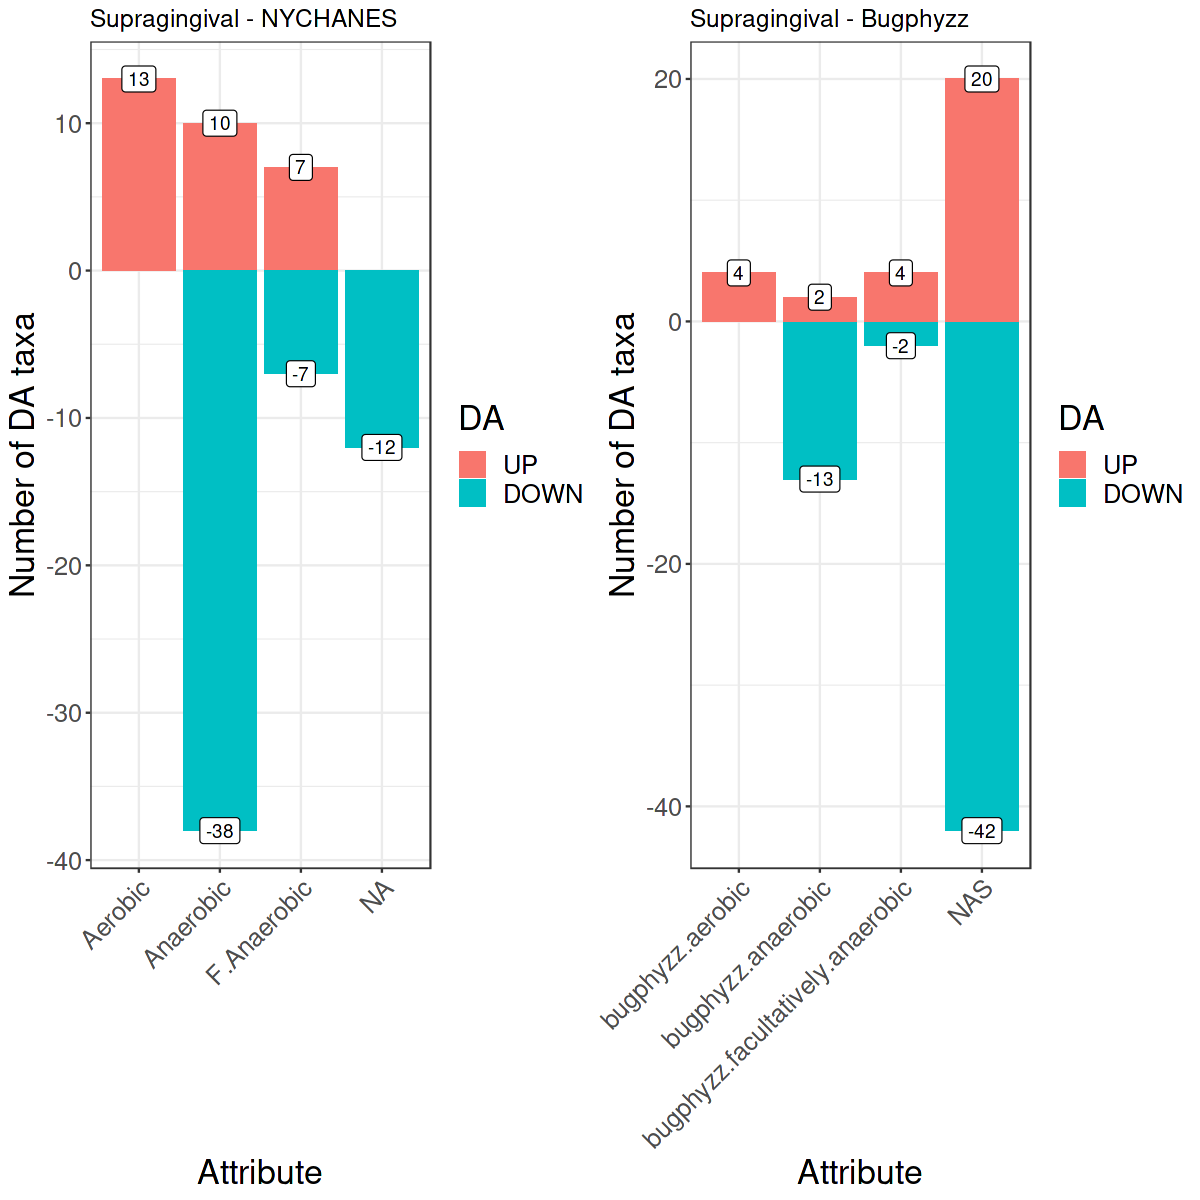

In [24]:
options(repr.plot.width = 10, repr.plot.height = 10)
ggpubr::ggarrange(p1, p2, align = "h")

## Enrichment with Fisher's exact test and odds ratio

In [25]:
# Convert from deseq object to SummarizedExperiment
seGingivalDESEQ <- SummarizedExperiment::SummarizedExperiment(
    assays = S4Vectors::SimpleList(counts = counts(ddsGingival)),
    rowData = rowData(ddsGingival),
    colData = colData(ddsGingival)
)

In [26]:
seGingivalDESEQ

class: SummarizedExperiment 
dim: 892 76 
metadata(0):
assays(1): counts
rownames(892): OTU_97.31247 OTU_97.44487 ... OTU_97.45365 OTU_97.45307
rowData names(47): SUPERKINGDOM PHYLUM ... DA.UP DA.DOWN
colnames(76): 700023057 700023179 ... 700114009 700114338
colData names(10): RSID VISITNO ... sizeFactor replaceable

### NYC HANES BIOSIS

In [27]:
nyc_hanes_attributes <- c("nychanes.Aerobic", "nychanes.Anaerobic", "nychanes.F.Anaerobic")
contingency_tbls_nychanes <- contingencyTable(seGingivalDESEQ, diffcols = c("DA.UP", "DA.DOWN"), sigcols = nyc_hanes_attributes)

In [28]:
lapply(contingency_tbls_nychanes, function(x) knitr::kable(x))

$DA.UP_nychanes.Aerobic


|        | nychanes.Aerobic| Notnychanes.Aerobic|
|:-------|----------------:|-------------------:|
|Diff    |               13|                  17|
|NotDiff |              186|                 676|

$DA.UP_nychanes.Anaerobic


|        | nychanes.Anaerobic| Notnychanes.Anaerobic|
|:-------|------------------:|---------------------:|
|Diff    |                 10|                    20|
|NotDiff |                315|                   547|

$DA.UP_nychanes.F.Anaerobic


|        | nychanes.F.Anaerobic| Notnychanes.F.Anaerobic|
|:-------|--------------------:|-----------------------:|
|Diff    |                    7|                      23|
|NotDiff |                  284|                     578|

$DA.DOWN_nychanes.Aerobic


|        | nychanes.Aerobic| Notnychanes.Aerobic|
|:-------|----------------:|-------------------:|
|Diff    |                0|                  57|
|NotDiff |              199|                 636|

$DA.DOWN_nychanes.Anaerobic


|     

In [29]:
fisher_nychanes <- enrichmentTest(contingency_tbls_nychanes) %>% 
    suppressWarnings() %>% 
    separate(col = con.table, into = c("Direction", "Attribute"), sep = "_") %>% 
    mutate(Direction = sub("^DA\\.", "", Direction), Attribute = sub("nychanes\\.", "", Attribute))

In [30]:
fisher_nychanes

Direction,Attribute,p.value,odds.ratio,ci.up,ci.lo
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
DOWN,Anaerobic,1.624252e-06,3.76673356,6.578516,2.156760161
UP,Aerobic,7.315535e-03,2.79823822,5.731377,1.366187748
UP,Anaerobic,7.051630e-01,0.88883306,1.867638,0.423007033
UP,F.Anaerobic,9.068746e-01,0.64895487,1.462644,0.287932180
DOWN,F.Anaerobic,9.999337e-01,0.28789434,0.614935,0.134783595
DOWN,Aerobic,1.000000e+00,0.02774327,0.201581,0.003818263


#### Plot of Odds Ratio

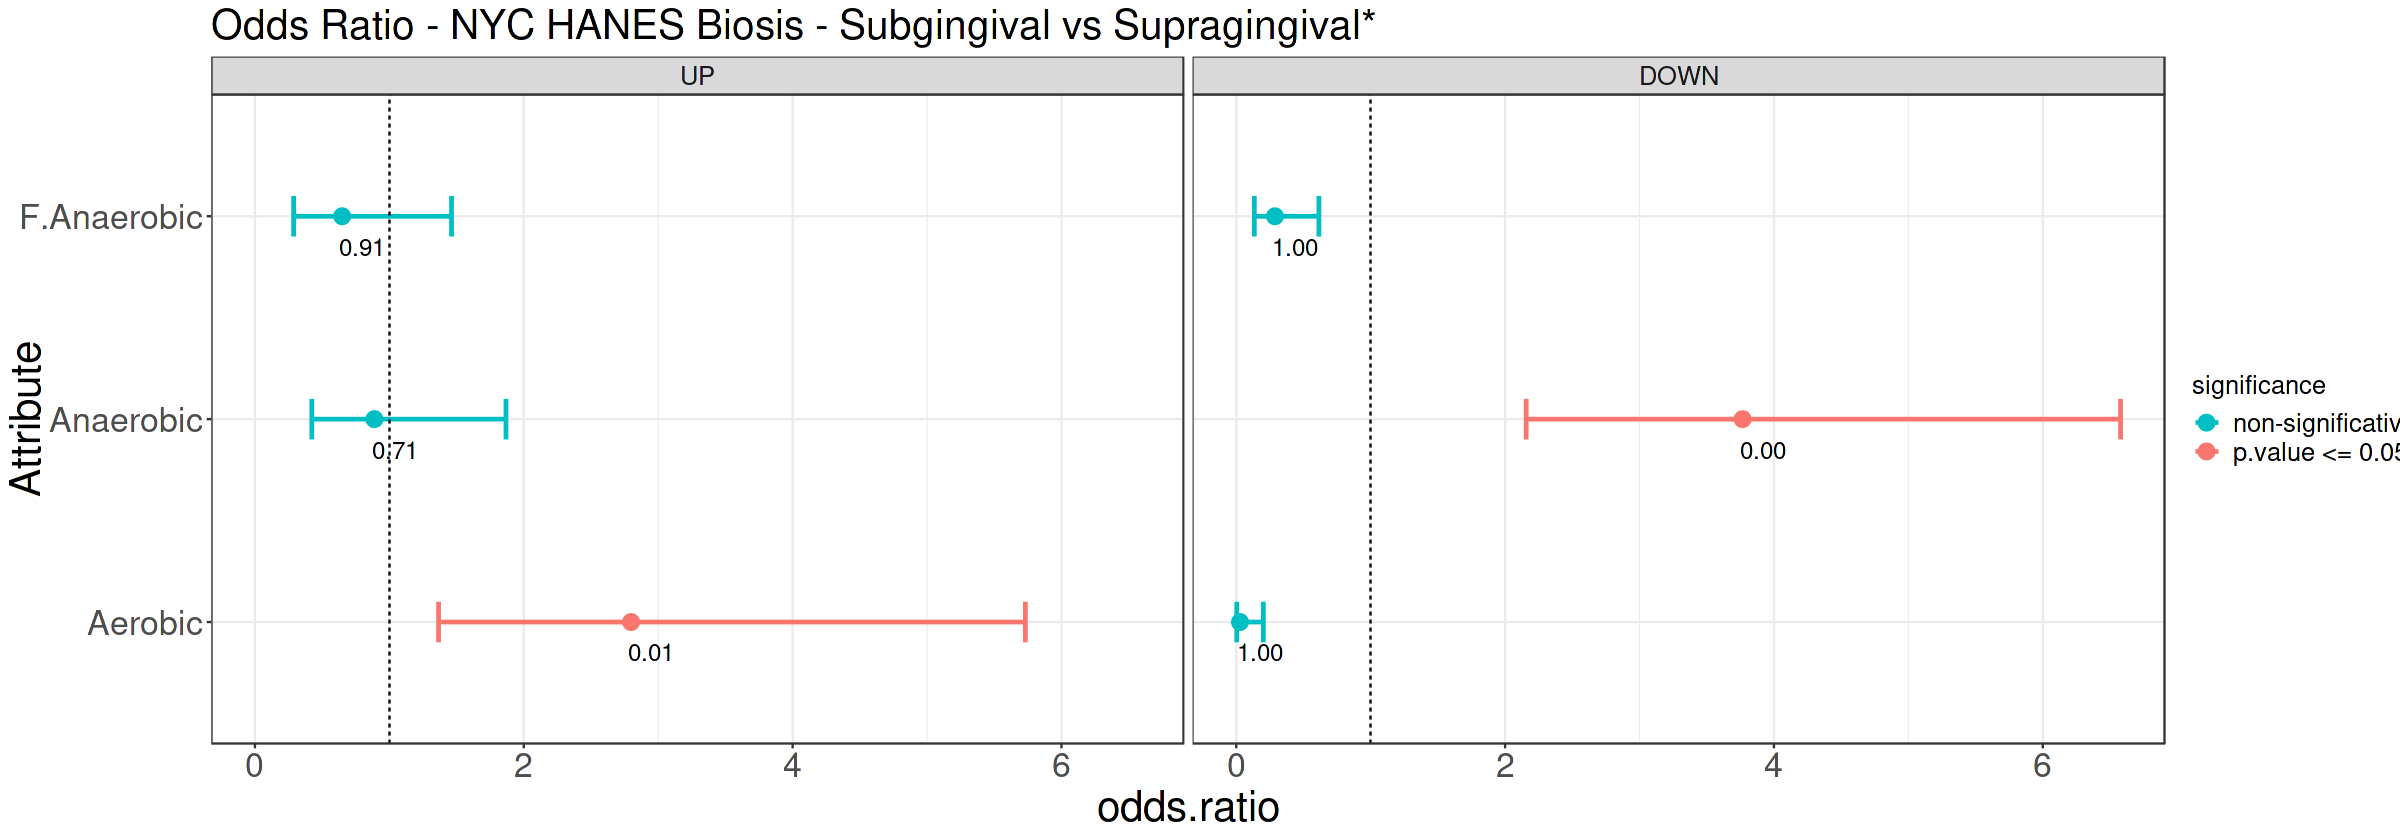

In [31]:
options(repr.plot.width = 20, repr.plot.height = 7)
(
p3 <- fisher_nychanes %>% 
    mutate(Direction = factor(Direction, levels = c("UP", "DOWN")),
          significance = ifelse(p.value <= 0.05, "p.value <= 0.05", "non-significative")) %>% 
    ggplot(aes(Attribute, odds.ratio)) +
    geom_point(aes(color = significance), size = 4) +
    geom_text(aes(label = sprintf("%0.2f", round(p.value, digits = 2))), nudge_y = 0.15, nudge_x = -0.15, size = 5) +
    geom_errorbar(aes(ymin = ci.lo, ymax = ci.up, color = significance), width = 0.2, size = 1) +
    geom_hline(yintercept = 1, linetype = 2) +
    facet_wrap(~Direction) +
    scale_color_discrete(direction = -1) +
    labs(title = "Odds Ratio - NYC HANES Biosis - Subgingival vs Supragingival*") +   
    theme_bw() +
    theme(title = element_text(size = 20),
        axis.text = element_text(size = 20),
        axis.title = element_text(size = 25),
        legend.text = element_text(size = 15),
        legend.title = element_text(size = 15),
        strip.text = element_text(size = 15)
    ) +
    coord_flip()
)

### Bugphyzz

In [32]:
bugphyzz_attributes <- c("bugphyzz.aerobic", "bugphyzz.anaerobic", "bugphyzz.facultatively.anaerobic")
contingency_tbls_bugphyzz <- contingencyTable(seGingivalDESEQ, diffcols = c("DA.UP", "DA.DOWN"), sigcols = bugphyzz_attributes)

In [33]:
lapply(contingency_tbls_bugphyzz, function(x) knitr::kable(x))

$DA.UP_bugphyzz.aerobic


|        | bugphyzz.aerobic| Notbugphyzz.aerobic|
|:-------|----------------:|-------------------:|
|Diff    |                4|                  26|
|NotDiff |              115|                 747|

$DA.UP_bugphyzz.anaerobic


|        | bugphyzz.anaerobic| Notbugphyzz.anaerobic|
|:-------|------------------:|---------------------:|
|Diff    |                  2|                    28|
|NotDiff |                117|                   745|

$DA.UP_bugphyzz.facultatively.anaerobic


|        | bugphyzz.facultatively.anaerobic| Notbugphyzz.facultatively.anaerobic|
|:-------|--------------------------------:|-----------------------------------:|
|Diff    |                                4|                                  26|
|NotDiff |                               72|                                 790|

$DA.DOWN_bugphyzz.aerobic


|        | bugphyzz.aerobic| Notbugphyzz.aerobic|
|:-------|----------------:|-------------------:|
|Diff    |                0| 

In [34]:
fisher_bugphyzz <- enrichmentTest(contingency_tbls_bugphyzz) %>% 
    suppressWarnings() %>% 
    separate(col = con.table, into = c("Direction", "Attribute"), sep = "_") %>% 
    mutate(Direction = sub("^DA\\.", "", Direction), Attribute = sub("bugphyzz\\.", "", Attribute))

In [35]:
fisher_bugphyzz

Direction,Attribute,p.value,odds.ratio,ci.up,ci.lo
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
DOWN,anaerobic,0.03018077,2.07801867,3.9141903,1.103206854
UP,facultatively.anaerobic,0.24788120,1.85152895,4.9526547,0.692186246
UP,aerobic,0.58419017,1.09899534,2.9109750,0.414909350
UP,anaerobic,0.92682774,0.55655095,1.8560615,0.166885073
DOWN,facultatively.anaerobic,0.96485385,0.46042687,1.5066563,0.140704225
DOWN,aerobic,1.00000000,0.05213753,0.3799878,0.007153708


#### Plot of odds ratio

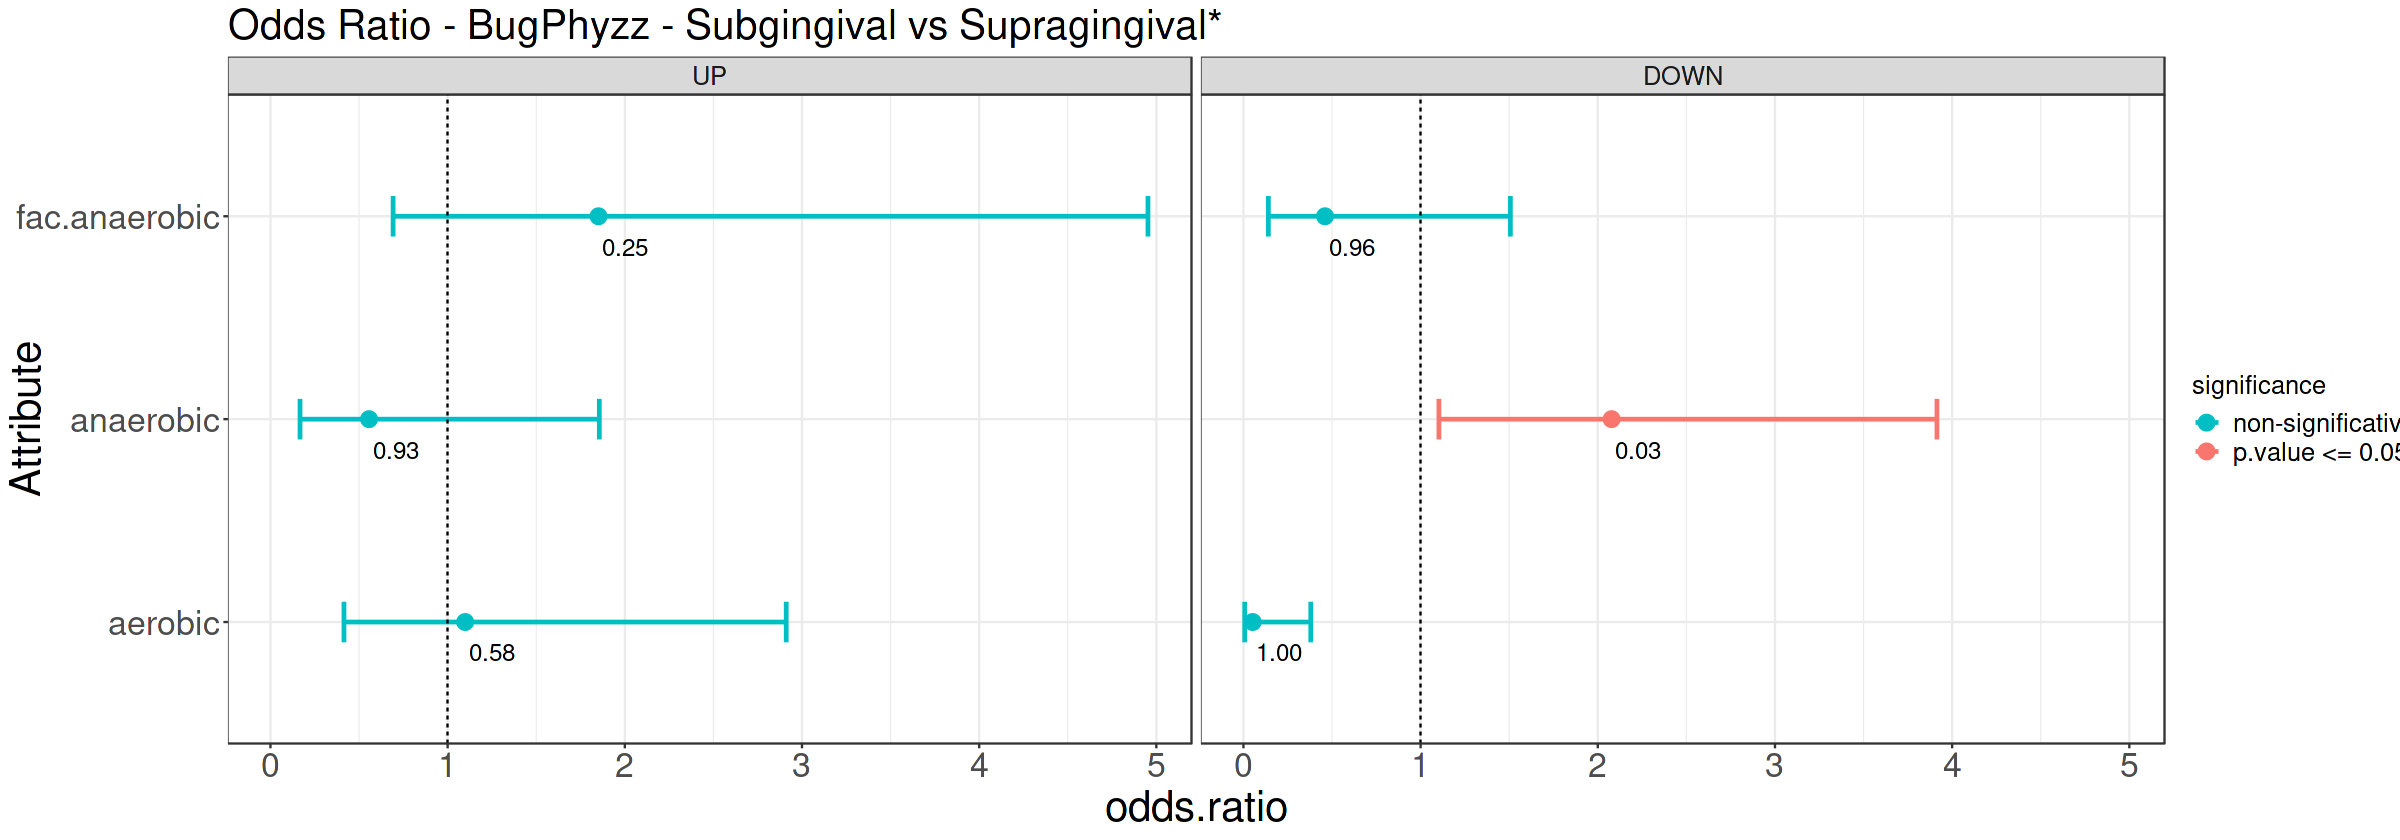

In [36]:
options(repr.plot.width = 20, repr.plot.height = 7)
(
p4 <- fisher_bugphyzz %>% 
    mutate(Direction = factor(Direction, levels = c("UP", "DOWN")),
          significance = ifelse(p.value <= 0.05, "p.value <= 0.05", "non-significative"))  %>% 
    ggplot(aes(Attribute, odds.ratio)) +
    geom_text(aes(label = sprintf("%0.2f", round(p.value, digits = 2))), nudge_y = 0.15, nudge_x = -0.15, size = 5) +
    geom_point(aes(color = significance), size = 4) +
    geom_errorbar(aes(ymin = ci.lo, ymax = ci.up, color = significance), width = 0.2, size = 1) +
    geom_hline(yintercept = 1, linetype = 2) +
    facet_wrap(~Direction) +
    scale_color_discrete(direction = -1) +
    scale_x_discrete(labels = c("aerobic", "anaerobic", "fac.anaerobic")) +
    labs(title = "Odds Ratio - BugPhyzz - Subgingival vs Supragingival*") +
    theme_bw() +
    theme(title = element_text(size = 20),
        axis.text = element_text(size = 20),
        axis.title = element_text(size = 25),
        legend.text = element_text(size = 15),
        legend.title = element_text(size = 15),
        strip.text = element_text(size = 15)
    ) +
    coord_flip()
)

### Comparison with EnrichmentBrowser

#### NYCHANES

A custom set of microbes with NYC HANES Biosis signatures:

In [37]:
nychanes_sets = microbeScores::makeMicrobeSets(x = seGingivalDESEQ, cols = c("nychanes.Aerobic", "nychanes.Anaerobic", "nychanes.F.Anaerobic"))

In [38]:
seGingivalDESEQ_ora_nychanes_default <- EnrichmentBrowser::sbea(method = "ora", se = seGingivalDESEQ,  gs = nychanes_sets, alpha = 0.1, perm=0)

In [49]:
EnrichmentBrowser::gsRanking(seGingivalDESEQ_ora_nychanes_default, signif.only = TRUE)

DataFrame with 1 row and 4 columns
            GENE.SET  NR.GENES NR.SIG.GENES      PVAL
         <character> <numeric>    <numeric> <numeric>
1 nychanes.Anaerobic       320           48  9.12e-06

Above, only one "term" was enriched: anaerobic. Because of the design passed to EnrichmentBrowser, this means that the anaerobic microbes are enriched in the set of differentially abundant taxa, i.e. they can be either "UP" or "DOWN".

Let's try to repruduce the results above using contigency tables and Fisher's exact test.

In [40]:
# EnrichmentBrowser filters lowly "expressed" features
filtered_otus <- rownames(seGingivalDESEQ_ora_nychanes_default$se)
length(filtered_otus) # There were 892 in the original dataset

[1] 800

Since the OTUs were filtered, it's necessary to re-count DA taxa and non-DA taxa to create a contingency matrix.

In [41]:
diff_otus <- filtered_otus[rowData(seGingivalDESEQ_ora_nychanes_default$se)$ADJ.PVAL < 0.1]
length(diff_otus) # There were 87 in the original dataset

[1] 75

In [42]:
sum(diff_otus %in% nychanes_sets$nychanes.Anaerobic) # The same number of taxa as before filtering

[1] 48

In [43]:
sum(filtered_otus %in% nychanes_sets$nychanes.Anaerobic) # There were 325 before filtering

[1] 320

In [44]:
a = sum(diff_otus %in% nychanes_sets$nychanes.Anaerobic) # DA, anaerobic
b = sum(diff_otus %in% nychanes_sets$nychanes.Anaerobic == FALSE) # DA, not aerobic
c = sum(filtered_otus %in% nychanes_sets$nychanes.Anaerobic) - a # Not DA, aerobic
d = length(filtered_otus) - a - b -c # Not DA, Not aerobic
m = matrix(c(a, b, c, d), ncol = 2, byrow = TRUE)
dimnames(m) = list(c("DA", "Not DA"), c("Anaerobic", "Not Anaerobic"))
addmargins(m)


,Anaerobic,Not Anaerobic,Sum
DA,48,27,75
Not DA,272,453,725
Sum,320,480,800


In [45]:
fisher.test(m, alternative = "g") # The output is the same as the output from EnrichmentBrowser


	Fisher's Exact Test for Count Data

data:  m
p-value = 9.119e-06
alternative hypothesis: true odds ratio is greater than 1
95 percent confidence interval:
 1.902331      Inf
sample estimates:
odds ratio 
  2.956602 


In [46]:
bugphyzz_sets <- microbeScores::makeMicrobeSets(x = seGingivalDESEQ, cols = c("bugphyzz.aerobic", "bugphyzz.anaerobic", "bugphyzz.facultatively.anaerobic"))

In [48]:
EnrichmentBrowser::sbea(method = "ora", se = seGingivalDESEQ, gs = bugphyzz_sets, alpha = 0.1, perm = 0) %>% 
    EnrichmentBrowser::gsRanking(signif.only = TRUE) # None was found significative

DataFrame with 1 row and 4 columns
            GENE.SET  NR.GENES NR.SIG.GENES      PVAL
         <character> <numeric>    <numeric> <numeric>
1 bugphyzz.anaerobic       116           15     0.016